In [1]:
import numpy as np, sys
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.autograd import Variable
from mpl_toolkits import mplot3d
from matplotlib import cm as cm, pyplot as plt, colors as mplotcolors
%load_ext autoreload
%autoreload 2

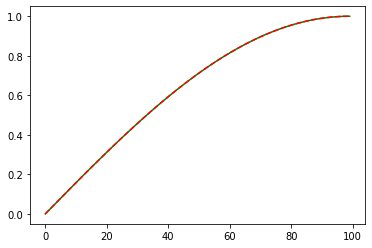

In [2]:
x = np.linspace(0,1,100)
x1 = np.sin(np.pi*x/2)
x2 = np.sin(np.pi*x/2) #1-np.cos(np.pi*x/2)
# x1 = 2/(1+np.exp(-10*x))-1
# x2 = 2/(1+np.exp(10-10*x))
plt.plot(x1, "g-", label="x1")
plt.plot(x2, "r--", label="x2")

In [3]:
def sine_sine_f(x, y):
    return (np.sin(np.pi*x/2) + np.sin(np.pi*y/2))/2.

def sine_cos_f(x, y):
    return (np.sin(np.pi*x/2) + (1.-np.cos(np.pi*y/2)))/2.

def plot_surface(x_space, y_space, f, labs=["x","y","z"]):
    X, Y = np.meshgrid(x_space, y_space)
    Z = f(X, Y).reshape(X.shape)
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                    cmap='viridis', edgecolor='none')
    ax.set_title('surface')
    ax.set_xlabel(labs[0])
    ax.set_ylabel(labs[1])
    ax.set_zlabel(labs[2])
    return X, Y

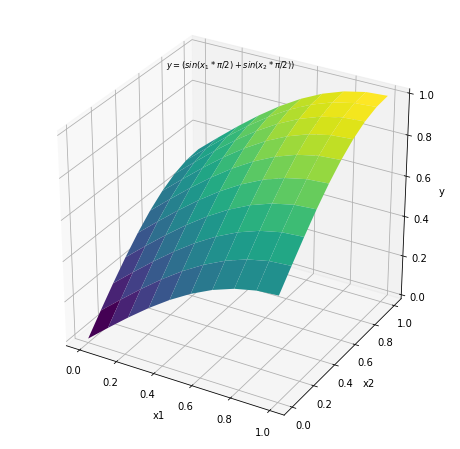

In [4]:
fig = plt.figure(figsize=(8,8))
x1_tr = np.linspace(0,1,10)
x2_tr = np.linspace(0,1,10)
x1_tr_mesh, x2_tr_mesh = plot_surface(x1_tr, x2_tr, sine_sine_f, labs=["x1","x2","y"])
plt.title(r'$y=(sin(x_1 * \pi/2)+sin(x_2 * \pi/2))$', fontsize='small')
plt.savefig("./figures/fn_sin_sin.png")

In [5]:
F_train = sine_sine_f
x_tr = torch.FloatTensor(np.dstack((x1_tr_mesh, x2_tr_mesh)).reshape(-1,2))
y_tr = torch.FloatTensor(list(map(lambda v: F_train(*v), x_tr.detach().numpy()))).reshape(-1,1)
x, y = Variable(x_tr, requires_grad=True), Variable(y_tr)
model = torch.nn.Sequential(
    torch.nn.Linear(2, 1024), torch.nn.ReLU(),
    torch.nn.Linear(1024, 1),
)
loss_fn = torch.nn.MSELoss()

[   10] loss: 0.7298, [   20] loss: 0.1516, [   30] loss: 0.0545, [   40] loss: 0.0219, [   50] loss: 0.0079, [   60] loss: 0.0029, [   70] loss: 0.0012, [   80] loss: 0.0006, [   90] loss: 0.0003, [  100] loss: 0.0002, [  110] loss: 0.0001, [  120] loss: 0.0001, [  130] loss: 0.0001, [  140] loss: 0.0001, [  150] loss: 0.0001, [  160] loss: 0.0001, [  170] loss: 0.0001, [  180] loss: 0.0000, [  190] loss: 0.0000, [  200] loss: 0.0000, [  210] loss: 0.0000, [  220] loss: 0.0000, [  230] loss: 0.0000, [  240] loss: 0.0000, [  250] loss: 0.0000, [  260] loss: 0.0000, [  270] loss: 0.0000, [  280] loss: 0.0000, [  290] loss: 0.0000, [  300] loss: 0.0000, [  310] loss: 0.0000, [  320] loss: 0.0000, [  330] loss: 0.0000, [  340] loss: 0.0000, [  350] loss: 0.0000, [  360] loss: 0.0000, [  370] loss: 0.0000, [  380] loss: 0.0000, [  390] loss: 0.0000, [  400] loss: 0.0000, [  410] loss: 0.0000, [  420] loss: 0.0000, [  430] loss: 0.0000, [  440] loss: 0.0000, [  450] loss: 0.0000, [  460] lo

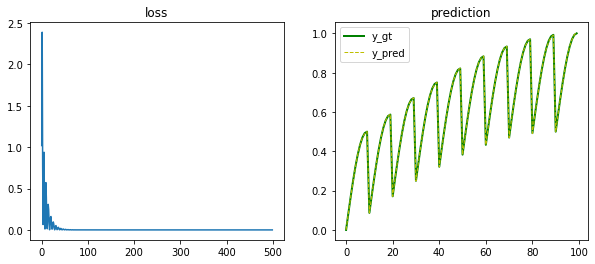

In [6]:
# optimizer = optim.SGD(model.parameters(), lr=1e-2)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
loss_lst = []
running_loss = 0.0
for t in range(500):
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    loss_lst.append(loss.item())
    running_loss += loss.item()
    if t % 10 == 9:
        print('[{:5d}] loss: {:.4f}'.format(t + 1, running_loss / 10), end=", ")
        running_loss = 0.0
    optimizer.zero_grad()
    loss.backward()    
    optimizer.step()
    
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(loss_lst)
plt.title("loss")
plt.subplot(122)
plt.plot(y, "g-", linewidth=2, label="y_gt")
plt.plot(model(x).detach().numpy(), "y--", linewidth=1, label="y_pred")
plt.title("prediction")
plt.legend()

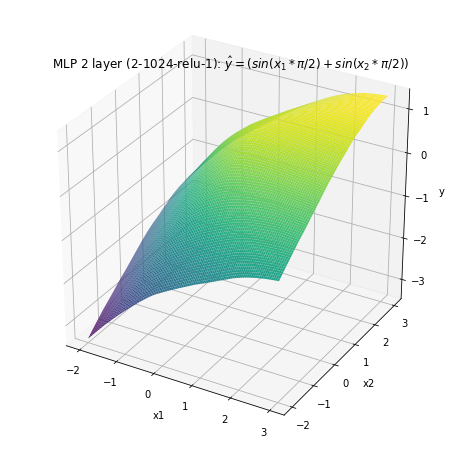

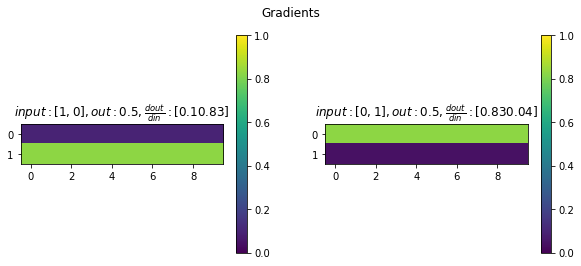

In [7]:
fig = plt.figure(figsize=(8,8))
x1_te = np.linspace(-2,3,100)
x2_te = np.linspace(-2,3,100)
mlp_f = lambda x1,x2: model(torch.FloatTensor(np.dstack((x1,x2)).reshape(-1,2))).detach().numpy()
_ = plot_surface(x1_te, x2_te, mlp_f, labs=["x1","x2","y"])
plt.title(r'MLP 2 layer (2-1024-relu-1): $\hat{y}=(sin(x_1 * \pi/2)+sin(x_2 * \pi/2))$')

plt.savefig("./figures/fn_sin_sin_mlp_approximation.png")

plt.figure(figsize=(10,4))
plt.subplot(121)
x_te = [1,0]
x1 = Variable(torch.FloatTensor(x_te), requires_grad=True)
y1 = model(x1)
y1.backward()
plt.imshow(np.repeat(x1.grad.numpy().reshape(-1,1), 10, 1), vmin=0, vmax=1)
plt.title(r"$input: {}, out: {}, \frac{{dout}}{{din}}: {}$".format(x_te, y1[0].detach().numpy().round(2), x1.grad.numpy().round(2)))
plt.colorbar()

plt.subplot(122)
x_te = [0,1]
x1 = Variable(torch.FloatTensor(x_te), requires_grad=True)
y1 = model(x1)
y1.backward()
plt.imshow(np.repeat(x1.grad.numpy().reshape(-1,1), 10, 1), vmin=0, vmax=1)
plt.title(r"$input: {}, out: {}, \frac{{dout}}{{din}}: {}$".format(x_te, y1[0].detach().numpy().round(2), x1.grad.numpy().round(2)))
plt.colorbar()
plt.suptitle("Gradients")

plt.savefig("./figures/fn_sin_sin_mlp_input_gradients.png")